# CP-SAT Assignment Problem

This notebook demonstrates OR-Tools **CP-SAT solver** integration with LumiX for combinatorial optimization, specifically solving a worker-task assignment problem.

## Problem Description

Assign tasks to workers to **minimize total cost** while satisfying:
- Each task must be assigned to exactly one worker
- Each worker has a maximum task capacity
- Each worker must be assigned at least one task
- Workers have different skill levels (reflected in cost penalties)

## Mathematical Formulation

**Decision Variables:**
$$x_{w,t} \in \{0, 1\} \quad \text{worker } w \text{ assigned to task } t$$

**Objective (Minimize Cost):**
$$\min \sum_{w,t} \text{cost}_{w,t} \cdot x_{w,t}$$

**Subject to:**
$$\sum_{w} x_{w,t} = 1 \quad \forall t \text{ (each task assigned once)}$$
$$\sum_{t} x_{w,t} \leq \text{max\_tasks}_w \quad \forall w \text{ (worker capacity)}$$
$$\sum_{t} x_{w,t} \geq 1 \quad \forall w \text{ (each worker assigned at least once)}$$

## Why CP-SAT?

CP-SAT (Constraint Programming - Satisfiability) excels at:
- Pure integer/binary problems
- Assignment and scheduling problems
- Combinatorial optimization
- Problems with logical constraints

## 1. Setup and Imports

In [1]:
# Standard library
from dataclasses import dataclass
from typing import Tuple, Dict

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# LumiX optimization library
from lumix import LXConstraint, LXLinearExpression, LXModel, LXOptimizer, LXVariable
from lumix.indexing import LXIndexDimension

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 2. Data Definition

In [2]:
@dataclass
class Worker:
    """Worker with skills and capacity."""
    id: int
    name: str
    hourly_rate: int  # $ per hour (integer for CP-SAT)
    max_tasks: int    # Maximum tasks capacity


@dataclass
class Task:
    """Task to be completed."""
    id: int
    name: str
    duration_hours: int  # Hours required
    priority: int        # 1-10 importance


# Sample workers
WORKERS = [
    Worker(1, "Alice", 25, 3),    # $25/hr, max 3 tasks
    Worker(2, "Bob", 20, 4),      # $20/hr, max 4 tasks
    Worker(3, "Charlie", 30, 2),  # $30/hr, max 2 tasks
    Worker(4, "Diana", 22, 3),    # $22/hr, max 3 tasks
]

# Sample tasks
TASKS = [
    Task(1, "Backend Development", 8, 9),
    Task(2, "Frontend Development", 6, 8),
    Task(3, "Database Optimization", 4, 7),
    Task(4, "API Design", 5, 8),
    Task(5, "Testing", 3, 6),
    Task(6, "Documentation", 2, 5),
    Task(7, "Code Review", 3, 7),
]

# Skill penalty matrix: (worker_id, task_id) -> penalty
# 0 = perfect fit, higher = less suited
ASSIGNMENT_PENALTIES: Dict[tuple, int] = {
    # Alice: Good at backend, API design
    (1, 1): 0, (1, 2): 20, (1, 3): 10, (1, 4): 5, (1, 5): 15, (1, 6): 25, (1, 7): 10,
    # Bob: Jack of all trades, master of testing
    (2, 1): 15, (2, 2): 10, (2, 3): 15, (2, 4): 10, (2, 5): 0, (2, 6): 10, (2, 7): 5,
    # Charlie: Expert backend and database
    (3, 1): 0, (3, 2): 30, (3, 3): 0, (3, 4): 10, (3, 5): 20, (3, 6): 35, (3, 7): 15,
    # Diana: Good at frontend and documentation
    (4, 1): 20, (4, 2): 0, (4, 3): 25, (4, 4): 10, (4, 5): 10, (4, 6): 0, (4, 7): 8,
}


def get_assignment_cost(worker: Worker, task: Task) -> int:
    """Total cost = base rate * hours + skill penalty."""
    penalty = ASSIGNMENT_PENALTIES.get((worker.id, task.id), 50)
    return worker.hourly_rate * task.duration_hours + penalty


print(f"Workers: {len(WORKERS)}")
print(f"Tasks: {len(TASKS)}")
print(f"Total Worker Capacity: {sum(w.max_tasks for w in WORKERS)} tasks")

Workers: 4
Tasks: 7
Total Worker Capacity: 12 tasks


### Visualize Worker and Task Data

In [3]:
# Worker summary
worker_df = pd.DataFrame([
    {'Worker': w.name, 'Rate ($/hr)': w.hourly_rate, 'Max Tasks': w.max_tasks}
    for w in WORKERS
])

print("Workers:")
display(worker_df.set_index('Worker'))

# Task summary
task_df = pd.DataFrame([
    {'Task': t.name, 'Duration (hrs)': t.duration_hours, 'Priority': t.priority}
    for t in TASKS
])

print("\nTasks:")
display(task_df.set_index('Task'))

Workers:


,Rate ($/hr),Max Tasks
Worker,,
Alice,25,3
Bob,20,4
Charlie,30,2
Diana,22,3



Tasks:


,Duration (hrs),Priority
Task,,
Backend Development,8,9
Frontend Development,6,8
Database Optimization,4,7
API Design,5,8
Testing,3,6
Documentation,2,5
Code Review,3,7


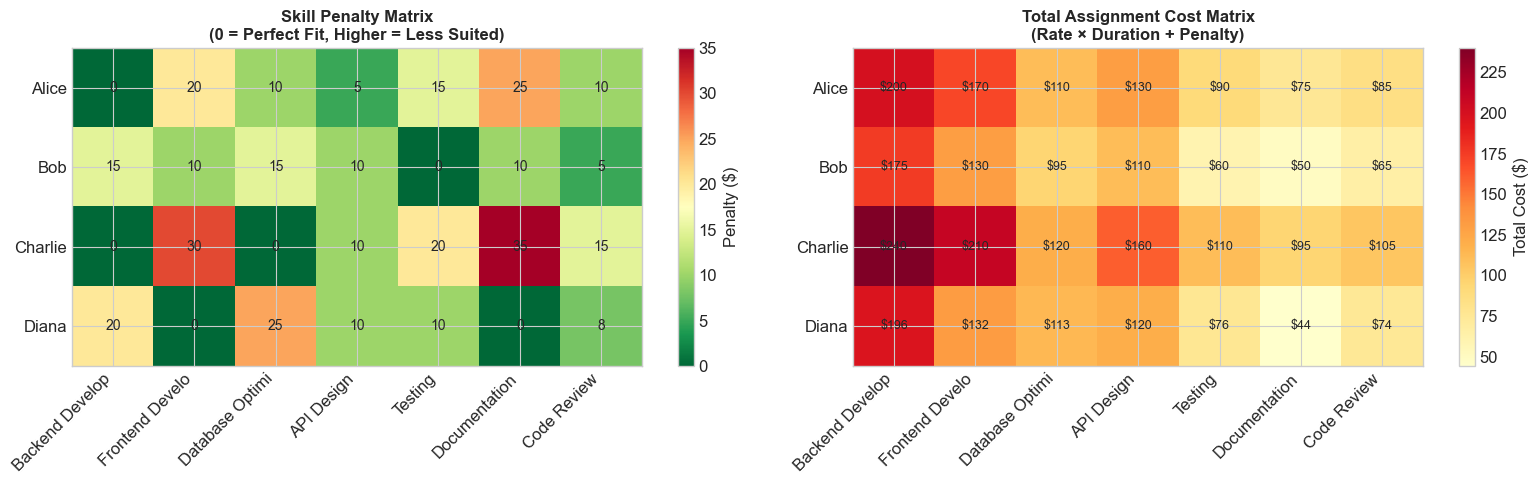

In [4]:
# Cost matrix heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Skill penalty matrix
ax1 = axes[0]
penalty_matrix = np.array([
    [ASSIGNMENT_PENALTIES.get((w.id, t.id), 50) for t in TASKS]
    for w in WORKERS
])

im1 = ax1.imshow(penalty_matrix, cmap='RdYlGn_r', aspect='auto')
ax1.set_xticks(np.arange(len(TASKS)))
ax1.set_yticks(np.arange(len(WORKERS)))
ax1.set_xticklabels([t.name[:15] for t in TASKS], rotation=45, ha='right')
ax1.set_yticklabels([w.name for w in WORKERS])

for i in range(len(WORKERS)):
    for j in range(len(TASKS)):
        ax1.text(j, i, f'{penalty_matrix[i,j]}', ha='center', va='center', fontsize=10)

ax1.set_title('Skill Penalty Matrix\n(0 = Perfect Fit, Higher = Less Suited)', fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=ax1, label='Penalty ($)')

# Total cost matrix
ax2 = axes[1]
cost_matrix = np.array([
    [get_assignment_cost(w, t) for t in TASKS]
    for w in WORKERS
])

im2 = ax2.imshow(cost_matrix, cmap='YlOrRd', aspect='auto')
ax2.set_xticks(np.arange(len(TASKS)))
ax2.set_yticks(np.arange(len(WORKERS)))
ax2.set_xticklabels([t.name[:15] for t in TASKS], rotation=45, ha='right')
ax2.set_yticklabels([w.name for w in WORKERS])

for i in range(len(WORKERS)):
    for j in range(len(TASKS)):
        ax2.text(j, i, f'${cost_matrix[i,j]}', ha='center', va='center', fontsize=9)

ax2.set_title('Total Assignment Cost Matrix\n(Rate × Duration + Penalty)', fontsize=12, fontweight='bold')
plt.colorbar(im2, ax=ax2, label='Total Cost ($)')

plt.tight_layout()
plt.show()

## 3. Build the Optimization Model

In [5]:
def build_assignment_model() -> Tuple[LXModel, LXVariable]:
    """
    Build the worker-task assignment model.
    
    Uses cartesian product indexing for (Worker × Task) combinations.
    """
    
    # Binary variable: Worker assigned to task
    assignment = (
        LXVariable[Tuple[Worker, Task], int]("assignment")
        .binary()
        .indexed_by_product(
            LXIndexDimension(Worker, lambda w: w.id).from_data(WORKERS),
            LXIndexDimension(Task, lambda t: t.id).from_data(TASKS),
        )
    )

    # Create model
    model = LXModel("worker_task_assignment").add_variable(assignment)

    # Objective: Minimize total cost
    cost_expr = LXLinearExpression().add_multi_term(
        assignment,
        coeff=lambda w, t: get_assignment_cost(w, t),
    )
    model.minimize(cost_expr)

    # Constraint 1: Each task assigned to exactly one worker
    for task in TASKS:
        task_id = task.id
        model.add_constraint(
            LXConstraint(f"task_coverage_{task_id}")
            .expression(
                LXLinearExpression().add_multi_term(
                    assignment,
                    coeff=lambda w, t, tid=task_id: 1 if t.id == tid else 0,
                )
            )
            .eq()
            .rhs(1)
        )

    # Constraint 2: Worker capacity
    for worker in WORKERS:
        worker_id = worker.id
        model.add_constraint(
            LXConstraint(f"worker_capacity_{worker_id}")
            .expression(
                LXLinearExpression().add_multi_term(
                    assignment,
                    coeff=lambda w, t, wid=worker_id: 1 if w.id == wid else 0,
                )
            )
            .le()
            .rhs(worker.max_tasks)
        )

    # Constraint 3: Each worker must be assigned at least one task
    for worker in WORKERS:
        worker_id = worker.id
        model.add_constraint(
            LXConstraint(f"worker_min_assignment_{worker_id}")
            .expression(
                LXLinearExpression().add_multi_term(
                    assignment,
                    coeff=lambda w, t, wid=worker_id: 1 if w.id == wid else 0,
                )
            )
            .ge()
            .rhs(1)
        )

    return model, assignment


# Build the model
model, assignment = build_assignment_model()

print("Model Summary:")
print("=" * 50)
print(model.summary())

Model Summary:
LXModel: worker_task_assignment
  Variable Families: 1
  Constraint Families: 15
  Objective: min



## 4. Solve with CP-SAT

In [6]:
# Create optimizer with CP-SAT solver
optimizer = LXOptimizer().use_solver("cpsat")

# Solve
print("Solving with OR-Tools CP-SAT solver...")
solution = optimizer.solve(
    model,
    time_limit=10.0,      # 10 second limit
    num_search_workers=4,  # Parallel search
)

print(f"\nSolution Status: {solution.status}")
print(f"Total Cost: ${solution.objective_value:.0f}")
print(f"Solve Time: {solution.solve_time:.3f}s")

2025-12-12 18:16:16 - lumix.optimizer - INFO - Created model 'worker_task_assignment' with 1 variables and 15 constraints
2025-12-12 18:16:16 - lumix.optimizer - INFO - Starting solve with cpsat...
2025-12-12 18:16:16 - lumix.OR-Tools CP-SAT - WARNING - Failed to set CP-SAT parameter 'enable_sensitivity': Protocol message SatParameters has no "enable_sensitivity" field.
2025-12-12 18:16:16 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 724.0000 | Time: 0.01s


Solving with OR-Tools CP-SAT solver...

Solution Status: optimal
Total Cost: $724
Solve Time: 0.004s


## 5. Analyze the Results

In [7]:
# Extract assignments
worker_by_id = {w.id: w for w in WORKERS}
task_by_id = {t.id: t for t in TASKS}

assignments_list = []
worker_task_count = {w.id: 0 for w in WORKERS}

for (worker_id, task_id), value in solution.get_mapped(assignment).items():
    if value > 0.5:
        worker = worker_by_id[worker_id]
        task = task_by_id[task_id]
        cost = get_assignment_cost(worker, task)
        penalty = ASSIGNMENT_PENALTIES.get((worker_id, task_id), 50)
        
        assignments_list.append({
            'Worker': worker.name,
            'Task': task.name,
            'Duration (hrs)': task.duration_hours,
            'Base Cost ($)': worker.hourly_rate * task.duration_hours,
            'Skill Penalty ($)': penalty,
            'Total Cost ($)': cost
        })
        worker_task_count[worker_id] += 1

assignments_df = pd.DataFrame(assignments_list)

print("\n" + "=" * 70)
print("OPTIMAL ASSIGNMENT")
print("=" * 70)
display(assignments_df)


OPTIMAL ASSIGNMENT


,Worker,Task,Duration (hrs),Base Cost ($),Skill Penalty ($),Total Cost ($)
0,Alice,API Design,5,125,5,130
1,Bob,Backend Development,8,160,15,175
2,Bob,Frontend Development,6,120,10,130
3,Bob,Testing,3,60,0,60
4,Bob,Code Review,3,60,5,65
5,Charlie,Database Optimization,4,120,0,120
6,Diana,Documentation,2,44,0,44


In [8]:
# Worker utilization
util_data = []
for worker in WORKERS:
    assigned = worker_task_count[worker.id]
    util_data.append({
        'Worker': worker.name,
        'Tasks Assigned': assigned,
        'Max Capacity': worker.max_tasks,
        'Utilization (%)': (assigned / worker.max_tasks) * 100
    })

util_df = pd.DataFrame(util_data)

print("\n" + "=" * 70)
print("WORKER UTILIZATION")
print("=" * 70)
display(util_df.set_index('Worker'))


WORKER UTILIZATION


,Tasks Assigned,Max Capacity,Utilization (%)
Worker,,,
Alice,1,3,33.333333
Bob,4,4,100.000000
Charlie,1,2,50.000000
Diana,1,3,33.333333


## 6. Visualize the Optimal Assignment

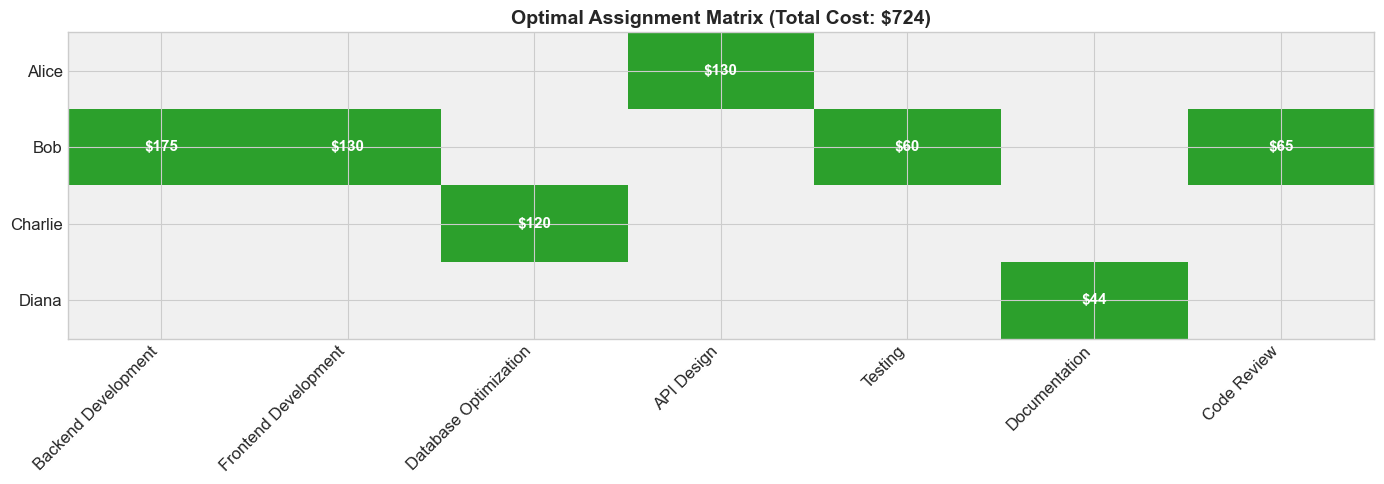

In [9]:
# Assignment matrix heatmap
fig, ax = plt.subplots(figsize=(14, 5))

# Create assignment matrix
assign_matrix = np.zeros((len(WORKERS), len(TASKS)))
cost_labels = np.zeros((len(WORKERS), len(TASKS)))

for (worker_id, task_id), value in solution.get_mapped(assignment).items():
    w_idx = next(i for i, w in enumerate(WORKERS) if w.id == worker_id)
    t_idx = next(i for i, t in enumerate(TASKS) if t.id == task_id)
    assign_matrix[w_idx, t_idx] = value
    if value > 0.5:
        cost_labels[w_idx, t_idx] = get_assignment_cost(worker_by_id[worker_id], task_by_id[task_id])

# Custom colormap
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#f0f0f0', '#2ca02c'])

im = ax.imshow(assign_matrix, cmap=cmap, aspect='auto', vmin=0, vmax=1)

ax.set_xticks(np.arange(len(TASKS)))
ax.set_yticks(np.arange(len(WORKERS)))
ax.set_xticklabels([t.name for t in TASKS], rotation=45, ha='right')
ax.set_yticklabels([w.name for w in WORKERS])

# Add cost labels for assignments
for i in range(len(WORKERS)):
    for j in range(len(TASKS)):
        if assign_matrix[i, j] > 0.5:
            ax.text(j, i, f'${cost_labels[i, j]:.0f}', ha='center', va='center', 
                    fontsize=11, fontweight='bold', color='white')

ax.set_title(f'Optimal Assignment Matrix (Total Cost: ${solution.objective_value:.0f})', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

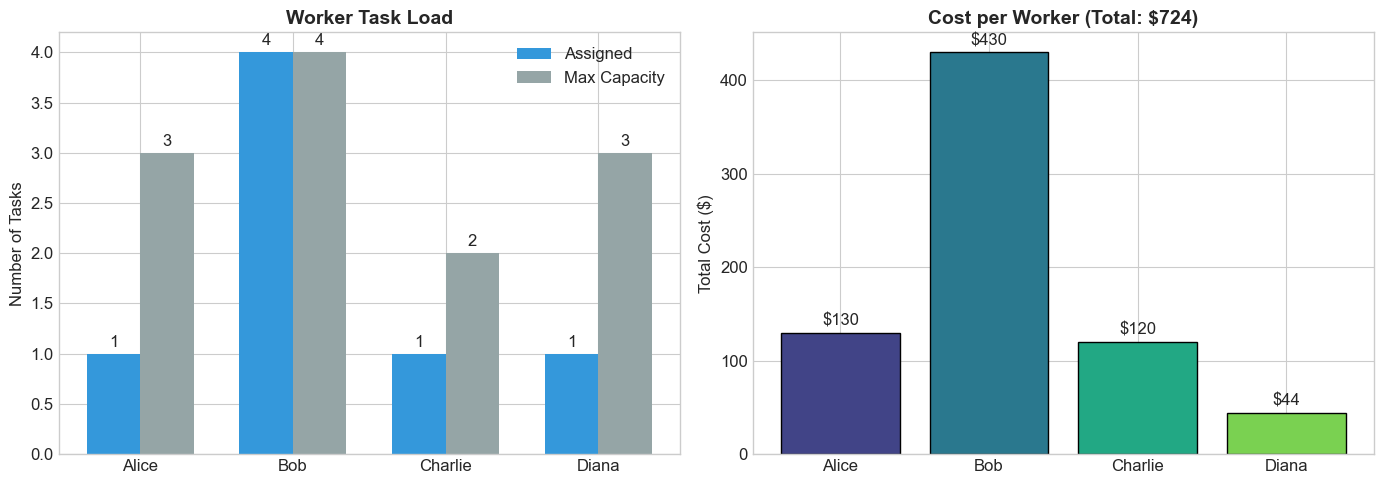

In [10]:
# Worker workload visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Task count per worker
ax1 = axes[0]
x = np.arange(len(WORKERS))
width = 0.35

assigned = [worker_task_count[w.id] for w in WORKERS]
capacity = [w.max_tasks for w in WORKERS]

bars1 = ax1.bar(x - width/2, assigned, width, label='Assigned', color='#3498db')
bars2 = ax1.bar(x + width/2, capacity, width, label='Max Capacity', color='#95a5a6')

ax1.set_ylabel('Number of Tasks')
ax1.set_title('Worker Task Load', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([w.name for w in WORKERS])
ax1.legend()
ax1.bar_label(bars1, padding=3)
ax1.bar_label(bars2, padding=3)

# Cost per worker
ax2 = axes[1]
worker_costs = {}
for _, row in assignments_df.iterrows():
    worker_costs[row['Worker']] = worker_costs.get(row['Worker'], 0) + row['Total Cost ($)']

costs = [worker_costs.get(w.name, 0) for w in WORKERS]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(WORKERS)))

bars = ax2.bar([w.name for w in WORKERS], costs, color=colors, edgecolor='black')
ax2.set_ylabel('Total Cost ($)')
ax2.set_title(f'Cost per Worker (Total: ${sum(costs):.0f})', fontsize=14, fontweight='bold')
ax2.bar_label(bars, fmt='$%.0f', padding=3)

plt.tight_layout()
plt.show()

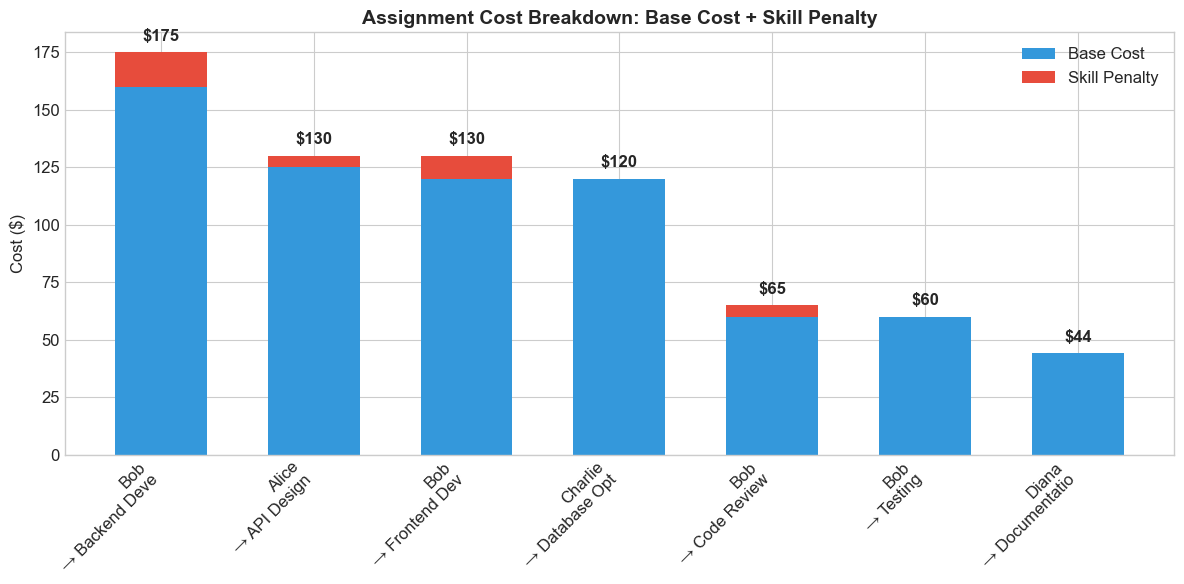

In [11]:
# Cost breakdown: base vs penalty
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by total cost
sorted_df = assignments_df.sort_values('Total Cost ($)', ascending=False)

x = np.arange(len(sorted_df))
width = 0.6

# Stacked bars
bars1 = ax.bar(x, sorted_df['Base Cost ($)'], width, label='Base Cost', color='#3498db')
bars2 = ax.bar(x, sorted_df['Skill Penalty ($)'], width, bottom=sorted_df['Base Cost ($)'], 
               label='Skill Penalty', color='#e74c3c')

ax.set_ylabel('Cost ($)')
ax.set_title('Assignment Cost Breakdown: Base Cost + Skill Penalty', fontsize=14, fontweight='bold')
ax.set_xticks(x)
labels = [f"{row['Worker']}\n→ {row['Task'][:12]}" for _, row in sorted_df.iterrows()]
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

# Add total labels
for i, (_, row) in enumerate(sorted_df.iterrows()):
    ax.annotate(f"${row['Total Cost ($)']:.0f}", (i, row['Total Cost ($)'] + 5), 
                ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Key Insights

### What We Learned

1. **CP-SAT Solver**: Specialized for integer/binary problems, often faster than LP solvers for combinatorial optimization

2. **Assignment Problem Structure**: 
   - Each task → exactly one worker (equality constraint)
   - Each worker → at most N tasks (inequality constraint)

3. **Skill-Based Costs**: The penalty matrix captures worker-task compatibility, encouraging assignments that match skills

4. **Multi-Model Indexing**: `(Worker × Task)` cartesian product naturally models assignment problems

### When to Use CP-SAT

- Pure integer/binary problems (no continuous variables)
- Scheduling and assignment problems
- Problems with logical constraints (if-then, all-different)
- When LP relaxation doesn't help much

## 8. Extensions & Exercises

1. **Skill requirements**: Some tasks require specific skills
2. **Team constraints**: Certain workers must work together
3. **Sequential tasks**: Some tasks depend on others
4. **Maximize priority**: Multi-objective with cost and priority
5. **Fairness**: Balance workload more evenly